# Imports and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

In [2]:
data = pd.read_csv('data/st.csv')
# data.head()
data.describe()

,Price,Year,Mileage,Distance,Private,Generation
count,163.000000,163.000000,163.000000,163.000000,163.000000,163.000000
mean,8514.147239,2015.852761,62636.717791,170.742331,0.331288,7.073620
std,2330.041284,1.306362,24012.078352,65.825957,0.472127,0.261956
min,3030.000000,2014.000000,19000.000000,7.000000,0.000000,7.000000
25%,6797.000000,2015.000000,44500.000000,135.500000,0.000000,7.000000
50%,8500.000000,2016.000000,60600.000000,167.000000,0.000000,7.000000
75%,9892.500000,2017.000000,76177.000000,202.000000,1.000000,7.000000
max,14995.000000,2020.000000,164530.000000,357.000000,1.000000,8.000000


# Graphs

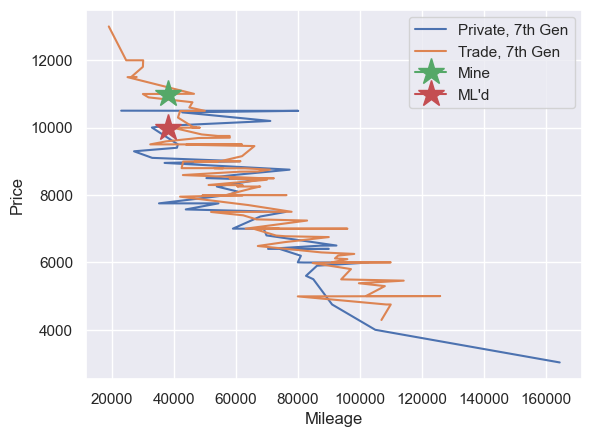

In [69]:
private_gen7_data = data[(data['Private'] == 1) & (data['Generation'] == 7)]
trade_gen7_data = data[(data['Private'] == 0) & (data['Generation'] == 7)]

y_private = private_gen7_data['Price']
y_trade = trade_gen7_data['Price']

x2p = private_gen7_data['Mileage']
x2t = trade_gen7_data['Mileage']

plt.plot(x2p, y_private, label='Private, 7th Gen')
plt.plot(x2t, y_trade, label='Trade, 7th Gen')
plt.plot(38000, 10995, '*-', markersize=20, label='Mine')
plt.plot(38000, 9995, '*-', markersize=20, label="ML'd")

plt.xlabel('Mileage')
plt.ylabel('Price')
plt.legend()

plt.show()

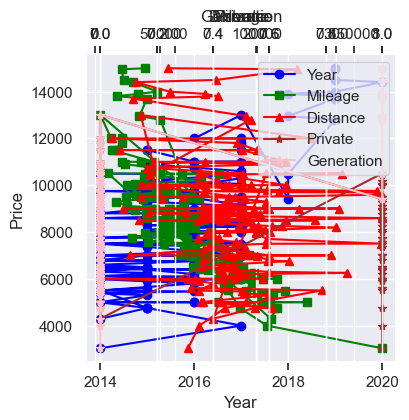

In [65]:
y = data['Price']
x1 = data['Year']
x2 = data['Mileage']
x3 = data['Distance']
x4 = data['Private']
x5 = data['Generation']

fig, ax1 = plt.subplots(figsize=(4, 4))

ax1.plot(x1, y, 'o-', label='Year', color='blue')
ax1.set_ylabel('Price')
ax1.set_xlabel('Year')

ax2 = ax1.twiny()
ax2.plot(x2, y, 's-', label='Mileage', color='green')
ax2.set_xlabel('Mileage')

ax3 = ax1.twiny()
ax3.plot(x3, y, '^-', label='Distance', color='red')
ax3.set_xlabel('Distance')

ax4 = ax1.twiny()
ax4.plot(x4, y, '*-', label='Private', color='brown')
ax4.set_xlabel('Private')

ax5 = ax1.twiny()
ax5.plot(x5, y, '*-', label='Generation', color='pink')
ax5.set_xlabel('Generation')

fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

plt.show()

# Modelling

In [15]:
X = data.drop(['Price'], axis=1).copy()
y = data['Price'].copy()

mine = pd.DataFrame({
    'Year': [2017],
    'Mileage': [38000],
    'Distance': [1],
    'Private': [1],
    'Generation': [7]
})

In [17]:
variables = data[['Year', 'Mileage', 'Distance', 'Private', 'Generation']]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["features"] = variables.columns
vif

,VIF,features
0,1013.143048,Year
1,8.317946,Mileage
2,8.217171,Distance
3,1.822719,Private
4,960.102784,Generation


## No split

In [18]:
model_lr = LinearRegression()
model_lr.fit(X,y)
p_lr = model_lr.predict(mine).astype(int)
model_lr_summary = pd.DataFrame(X.columns.values, columns=['Features'])
model_lr_summary['Weights'] = model_lr.coef_

model_dtr = DecisionTreeRegressor()
model_dtr.fit(X,y)
p_dtr = model_dtr.predict(mine).astype(int)

model_rfr = RandomForestRegressor()
model_rfr.fit(X,y)
p_rfr = model_rfr.predict(mine).astype(int)

model_gbr = GradientBoostingRegressor(random_state=42)
model_gbr.fit(X,y)
p_gbr = model_gbr.predict(mine).astype(int)

model_xgb = XGBRegressor(random_state=42)
model_xgb.fit(X,y)
p_xgb = model_xgb.predict(mine).astype(int)

print(f'Linear:         {p_lr[0]}')
print(f'Decision Tree:  {p_dtr[0]}')
print(f'Random Forest:  {p_rfr[0]}')
print(f'Gradient Boost: {p_gbr[0]}')
print(f'XGB Boost:      {p_xgb[0]}')
print(f'Mean:           {int(np.mean([p_lr,p_dtr,p_rfr,p_gbr,p_xgb]))}')

model_lr_summary

Linear:         9952
Decision Tree:  10050
Random Forest:  10275
Gradient Boost: 10369
XGB Boost:      10592
Mean:           10247


,Features,Weights
0,Year,346.824903
1,Mileage,-0.066038
2,Distance,0.579833
3,Private,-397.593761
4,Generation,3024.158200


## Split

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_lr = LinearRegression()
model_lr.fit(X_train,y_train)
p_lr = model_lr.predict(X_test).astype(int)

model_dtr = DecisionTreeRegressor(random_state=42)
model_dtr.fit(X_train,y_train)
p_dtr = model_dtr.predict(X_test).astype(int)

model_rfr = RandomForestRegressor(random_state=42, n_estimators=100, criterion='absolute_error', max_depth=10, min_samples_split=5)
model_rfr.fit(X_train,y_train)
p_rfr = model_rfr.predict(X_test).astype(int)

model_gbr = GradientBoostingRegressor(random_state=42)
model_gbr.fit(X_train,y_train)
p_gbr = model_gbr.predict(X_test).astype(int)

model_xgb = XGBRegressor(random_state=42)
model_xgb.fit(X_train,y_train)
p_xgb = model_xgb.predict(X_test).astype(int)

mae_lr = mean_absolute_error(y_test, p_lr)
mae_dtr = mean_absolute_error(y_test, p_dtr)
mae_rfr = mean_absolute_error(y_test, p_rfr)
mae_gbr = mean_absolute_error(y_test, p_gbr)
mae_xgb = mean_absolute_error(y_test, p_xgb)

print(f'Random Forest:\t\t{p_rfr[:5]}\t\tMAE: {int(mae_rfr)}\tPrediction: £{int(model_rfr.predict(mine)[0])}')
print(f'Linear:\t\t\t{p_lr[:5]}\t\tMAE: {int(mae_lr)}\tPrediction: £{int(model_lr.predict(mine)[0])}')
print(f'Gradient Boost:\t\t{p_gbr[:5]}\t\tMAE: {int(mae_gbr)}\tPrediction: £{int(model_gbr.predict(mine)[0])}')
print(f'XGB Boost:\t\t{p_xgb[:5]}\t\tMAE: {int(mae_xgb)}\tPrediction: £{int(model_xgb.predict(mine)[0])}')
print(f'Decision Tree:\t\t{p_dtr[:5]}\t\tMAE: {int(mae_dtr)}\tPrediction: £{int(model_dtr.predict(mine)[0])}')

Random Forest:		[9986 7825 9299 6290 7506]		MAE: 568	Prediction: £10398
Linear:			[10120  8180  9449  6304  8154]		MAE: 602	Prediction: £9807
Gradient Boost:		[10575  7884  9207  6234  7280]		MAE: 684	Prediction: £10354
XGB Boost:		[10287  7174  9752  6379  7659]		MAE: 777	Prediction: £10275
Decision Tree:		[10490  7275  8995  6000  6795]		MAE: 827	Prediction: £10050


## Tuning and experimenting

### Lots of random forests

In [46]:
results = []
for i in range(1,20):
    for j in range (2,20):
        for k in range(50,401,50):
            model = RandomForestRegressor(random_state=42, n_estimators=k, criterion='absolute_error', max_depth=i, min_samples_split=j)
            mae = int(score_model(model))
            result = {f'{k} {i} {j}':int(mae)}
            print(f'{k}|{i}|{j}', end=' ')
            results.append(result)
sorted_results = sorted(results, key=lambda x: list(x.values())[0])
print()
for result in sorted_results[:10]:
    model, number = list(result.items())[0]
    print(f"{model}\t{number}")

50|1|2 100|1|2 150|1|2 200|1|2 250|1|2 300|1|2 350|1|2 400|1|2 50|1|3 100|1|3 150|1|3 200|1|3 250|1|3 300|1|3 350|1|3 400|1|3 50|1|4 100|1|4 150|1|4 200|1|4 250|1|4 300|1|4 350|1|4 400|1|4 50|1|5 100|1|5 150|1|5 200|1|5 250|1|5 300|1|5 350|1|5 400|1|5 50|1|6 100|1|6 150|1|6 200|1|6 250|1|6 300|1|6 350|1|6 400|1|6 50|1|7 100|1|7 150|1|7 200|1|7 250|1|7 300|1|7 350|1|7 400|1|7 50|1|8 100|1|8 150|1|8 200|1|8 250|1|8 300|1|8 350|1|8 400|1|8 50|1|9 100|1|9 150|1|9 200|1|9 250|1|9 300|1|9 350|1|9 400|1|9 50|1|10 100|1|10 150|1|10 200|1|10 250|1|10 300|1|10 350|1|10 400|1|10 50|1|11 100|1|11 150|1|11 200|1|11 250|1|11 300|1|11 350|1|11 400|1|11 50|1|12 100|1|12 150|1|12 200|1|12 250|1|12 300|1|12 350|1|12 400|1|12 50|1|13 100|1|13 150|1|13 200|1|13 250|1|13 300|1|13 350|1|13 400|1|13 50|1|14 100|1|14 150|1|14 200|1|14 250|1|14 300|1|14 350|1|14 400|1|14 50|1|15 100|1|15 150|1|15 200|1|15 250|1|15 300|1|15 350|1|15 400|1|15 50|1|16 100|1|16 150|1|16 200|1|16 250|1|16 300|1|16 350|1|16 400|1|16

### Cross validation and hyperparameter tuning

In [23]:
lr = LinearRegression()
scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print("Linear Regression CV MAE:", -scores.mean().astype(int))

print()

dt = DecisionTreeRegressor()
scores = cross_val_score(dt, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print("Decision Tree CV MAE:", -scores.mean().astype(int))

# Hyperparameter tuning for Decision Tree
param_grid = {'max_depth': [3, 5, 7, None], 'min_samples_split': [2, 5, 10]}
grid_search = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)
print("Best params for Decision Tree:", grid_search.best_params_)
print("Best CV MAE for Decision Tree:", -grid_search.best_score_.astype(int))

# Evaluate on test set
best_dt = grid_search.best_estimator_
y_pred = best_dt.predict(X_test)
print("Test MAE for Decision Tree:", mean_absolute_error(y_test, y_pred).astype(int))

print()

rf = RandomForestRegressor()
scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print("Random Forest CV MAE:", -scores.mean().astype(int))

Linear Regression CV MAE: 657

Decision Tree CV MAE: 1006
Best params for Decision Tree: {'max_depth': None, 'min_samples_split': 10}
Best CV MAE for Decision Tree: 899
Test MAE for Decision Tree: 790

Random Forest CV MAE: 779


### XGB grid search

In [24]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
print(f'Best parameters: {grid_search.best_params_}')
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse.astype(int)}')
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae.astype(int)}')

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Mean Squared Error: 695615
Mean Absolute Error: 688
